In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import plotly.express as px
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
stop_words = set(stopwords.words('english'))
def read_data(file_path):
    df = pd.read_csv(file_path, sep='\t')
    df = df[['claim', 'main_text', 'label']]
    df.dropna(axis=0, inplace=True)

    def preprocess_text(text):
        text = re.sub(r'[#\\\"$”“,:()–’\'/;\[\]{}—‘!+•%&-]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = text.lower()
        return ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    df['main_text'] = df['main_text'].apply(preprocess_text)
    df['claim'] = df['claim'].apply(preprocess_text)

    df = df[df['label'].str.contains('snopes') == False]
    label_dict = {'false': 0, 'true': 1, 'mixture': 2, 'unproven': 3}
    df['label'] = df['label'].map(label_dict)
    return df

In [3]:
def tokenize_data(data, tokenizer):
    return tokenizer(
        data["claim"].tolist(),
        data["main_text"].tolist(),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

In [4]:
file_paths = {
        "train": "train.tsv",
        "test": "test.tsv"
    }

In [6]:
def load_and_preprocess_data(file_paths):
    datasets = {}
    for key, path in file_paths.items():
        df = read_data(path)
        #df['top_k_sentences'] = df.apply(
        #    lambda row: retrieve_top_k_sentences(row['claim'], row['main_text'], model=sbert_model), axis=1
        #)
        datasets[key] = df
    return datasets

datasets = load_and_preprocess_data(file_paths)

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
#model_name = "allenai/scibert_scivocab_uncased"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#input_ids_train, attention_masks_train = get_input_and_attention(df1, tokenizer)
#bert_model = TransformerClassifier('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        # Store encodings and labels as tensors
        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Use clone().detach() instead of torch.tensor() for existing tensors
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx].clone().detach()
        return item


In [ ]:
class PUBHEALTHDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):

        labels = [int(label) if isinstance(label, float) else int(label) for label in labels]
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.encodings = encodings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

In [9]:
def prepare_datasets(datasets, tokenizer):
    tokenized_datasets = {}

    for key, df in datasets.items():
        df = df.dropna(subset=["label"])

        encodings = tokenize_data(df, tokenizer)
        tokenized_datasets[key] = PUBHEALTHDataset(encodings, df["label"].tolist())

    return tokenized_datasets

tokenized_datasets = prepare_datasets(datasets, tokenizer)

In [22]:
def train_model(train_dataset, model):
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="no",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.05,
        logging_dir="./logs",
        logging_steps=100
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset
    )
    trainer.train()
    return trainer

In [33]:
from sklearn.utils.class_weight import compute_class_weight
# Calculate class weights based on training labels
def calculate_class_weights(dataset):
    labels = dataset['label'].values
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(labels),
        y=labels
    )
    return torch.tensor(class_weights, dtype=torch.float)

In [41]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [34]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device)  # Move weights to GPU/CPU

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)  # Use weighted loss
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [42]:
def train_model_with_weights(train_dataset, model):
    # Calculate class weights
    class_weights = calculate_class_weights(datasets["train"])  # Using the train dataset

    # Define training arguments
    training_args = TrainingArguments(eval_strategy="no",
        output_dir="./results",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        num_train_epochs=4,
        weight_decay=0.05,
        logging_dir="./logs",
        logging_steps=10,
        save_strategy="epoch",
    )

    # Initialize the custom weighted trainer
    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        class_weights=class_weights
    )

    trainer.train()
    return trainer

In [29]:
label_mapping = {
    'false': 0,
    'true': 1,
    'mixture': 2,
    'unproven': 3
}

In [11]:
tokenized_datasets = prepare_datasets(datasets, tokenizer)

In [36]:
#model_name = "allenai/scibert_scivocab_uncased"
#tokenizer = AutoTokenizer.from_pretrained(model_name)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)
model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [45]:
trainer1 = train_model(
        tokenized_datasets["train"],
        model
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
100,0.615100
200,0.582500
300,0.478500
400,0.458300
500,0.359900
600,0.385800


In [43]:
trainer = train_model_with_weights(
        tokenized_datasets["train"],
        model
    )

Step,Training Loss
10,1.356300
20,1.429600
30,1.354600
40,1.368600
50,1.324700
60,1.216800
70,1.167300
80,1.223400
90,1.054300
100,1.093600


### Results

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
def evaluate_model(true_labels, predicted_labels, label_mapping):
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    true_labels_str = [reverse_mapping[label] for label in true_labels]
    predicted_labels_str = [reverse_mapping[label] for label in predicted_labels]

    print("Classification Report:\n", classification_report(true_labels_str, predicted_labels_str))
    cm = confusion_matrix(true_labels_str, predicted_labels_str, labels=list(label_mapping.keys()))
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [31]:
def evaluate_model_performance(trainer, test_dataset, test_labels, label_mapping):
    predictions = trainer.predict(test_dataset)
    predicted_labels = predictions.predictions.argmax(axis=1)
    evaluate_model(test_labels, predicted_labels, label_mapping)

Classification Report:
               precision    recall  f1-score   support

       false       0.66      0.61      0.63       388
     mixture       0.35      0.53      0.42       201
        true       0.89      0.73      0.80       599
    unproven       0.23      0.42      0.30        45

    accuracy                           0.65      1233
   macro avg       0.53      0.57      0.54      1233
weighted avg       0.71      0.65      0.67      1233



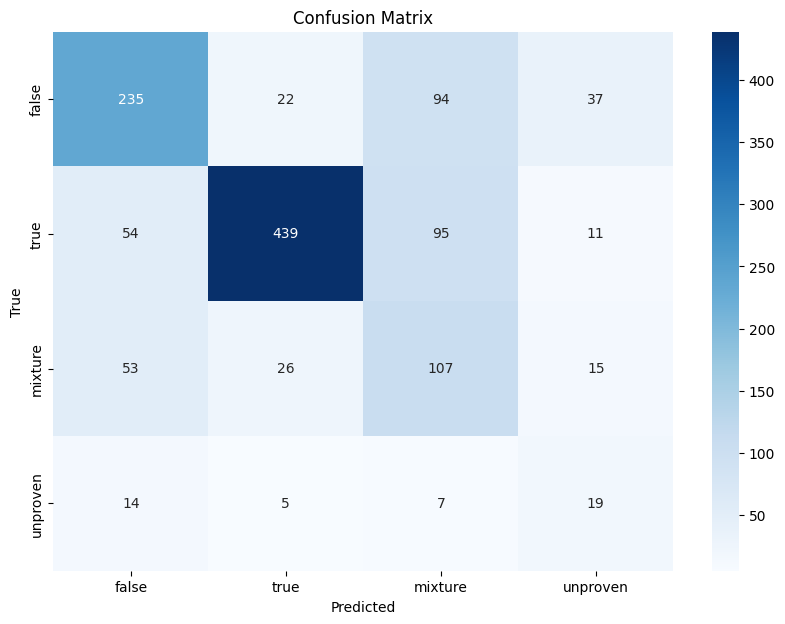

In [44]:
evaluate_model_performance(trainer, tokenized_datasets["test"], datasets["test"]["label"], label_mapping)

Classification Report:
               precision    recall  f1-score   support

       false       0.62      0.76      0.68       388
     mixture       0.36      0.30      0.32       201
        true       0.85      0.79      0.82       599
    unproven       0.34      0.27      0.30        45

    accuracy                           0.68      1233
   macro avg       0.54      0.53      0.53      1233
weighted avg       0.68      0.68      0.68      1233



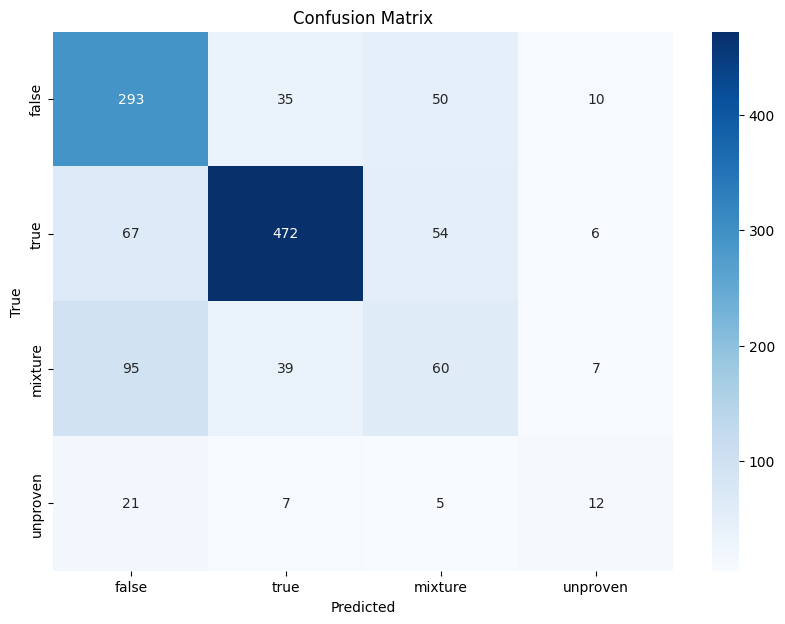

In [46]:
evaluate_model_performance(trainer1, tokenized_datasets["test"], datasets["test"]["label"], label_mapping)